In [1]:
import pandas as pd
import torch
import os

from torch_geometric.utils import one_hot
from torch_geometric.data import (
    InMemoryDataset,
    Data,
    download_url,
    extract_zip,
)

from rdkit import Chem
from rdkit.Chem import Draw
Draw.rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol

First of all, let's download the dataset and take a look at it.

In [2]:
! mkdir -p data
! wget -q https://github.com/vladislach/small-molecules/raw/main/structures.zip
! wget -q https://github.com/vladislach/small-molecules/raw/main/molecules.csv -O data/molecules.csv
! unzip -q -o structures.zip -d data/raw; rm structures.zip

In [3]:
df = pd.read_csv('data/molecules.csv')
df.style.format({'activity': '{:.2f}'}) \
                .hide(axis='index') \
                .set_table_styles([{'selector': 'thead th', 'props': [('text-align', 'center')]}]) \
                .set_properties(**{'text-align': 'left'})


id,name,smiles,activity,purchasable
X-0131,Ibuprofen,CC(C)Cc1ccc([C@@H](C)C(=O)O)cc1,3.70,1
X-0179,Lidocaine,CCN(CC)CC(=O)Nc1c(C)cccc1C,5.80,1
X-0258,Bimatoprost,CCNC(=O)CCC/C=C\C[C@@H]1[C@@H](/C=C/[C@@H](O)CCc2ccccc2)[C@H](O)C[C@@H]1O,0.70,1
X-1053,Diclofenac,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,12.20,1
X-2717,Metoprolol,COCCc1ccc(OCC(O)CNC(C)C)cc1,7.70,0
X-1362,Clopidogrel,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,10.10,0
X-0948,Salbutamol,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,9.10,0
X-2003,Lenvatinib,COc1cc2nccc(Oc3ccc(NC(=O)NC4CC4)c(Cl)c3)c2cc1C(N)=O,8.50,0
X-1432,Tafamidis,O=C(O)c1ccc2nc(-c3cc(Cl)cc(Cl)c3)oc2c1,15.50,1
X-0024,Naproxen,COc1ccc2cc([C@H](C)C(=O)O)ccc2c1,0.40,0


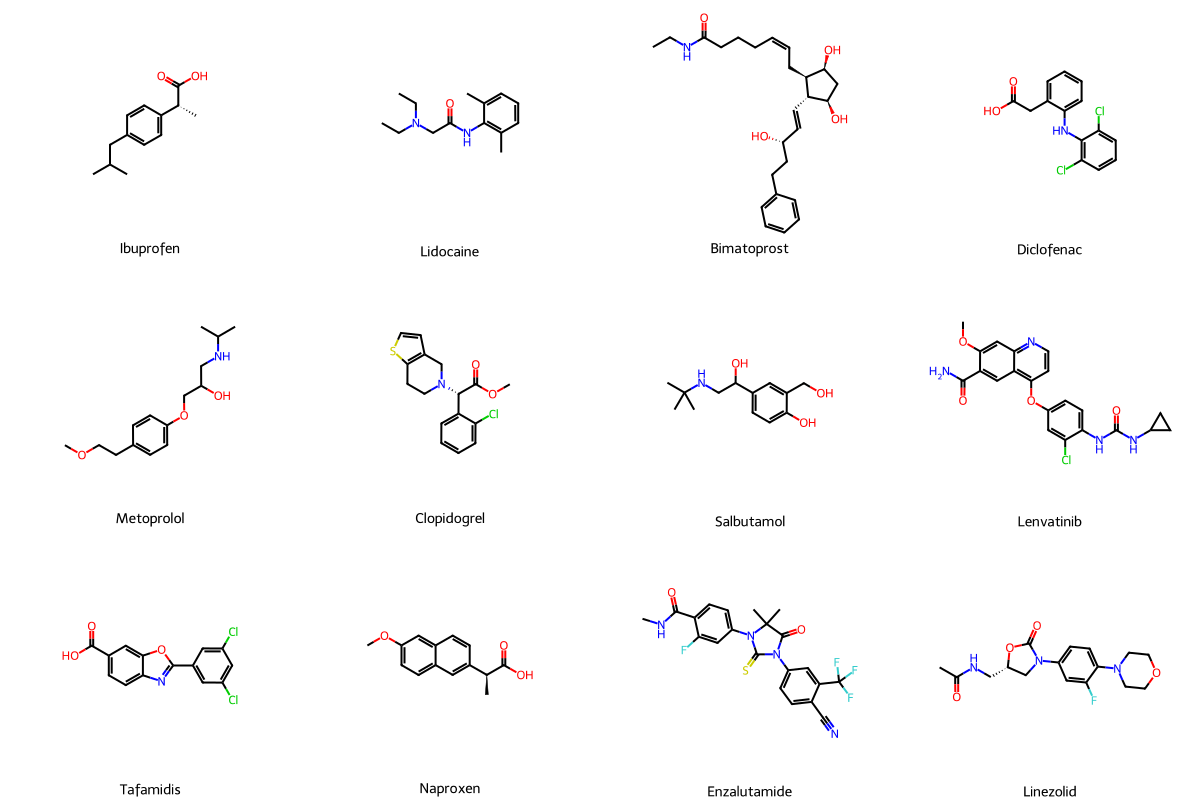

In [4]:
mols = [Chem.MolFromSmiles(smiles) for smiles in df['smiles']]

opts = Draw.MolDrawOptions()
opts.legendFontSize = 14

Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 270),
                     legends=df['name'].to_list(), drawOptions=opts, useSVG=True)

In [5]:
id = df.loc[df['name'] == 'Diclofenac', 'id'].values[0]
mol = Chem.MolFromMol2File(f'data/raw/{id}.mol2')
mb = Chem.MolToMolBlock(mol)

viewer = py3Dmol.view(width=800, height=400)
viewer.addModel(mb, "mol")
viewer.setStyle({'stick': {}})
viewer.zoomTo()
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

There are many features that you can get with RDKit, but we will focus on the following ones:

- Atomic Number (one-hot encoded)
- Total Number of Neighboring Atoms, one-hot encoded)
- Number of Connected Hydrogens (one-hot encoded)
- Hybridization (one-hot encoded)
- Aromaticity (True/False)
- Presence of the Atom in a Ring of a certain size (True/False for each size)

If you want to know more about the features that RDKit can provide, you can check the documentation [here](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html). Let's start by looking at what types of atoms we have in the dataset for each feature to see how we can one-encode them later.

In [6]:
print(f"Atomic Numbers: {set(atom.GetAtomicNum() for mol in mols for atom in mol.GetAtoms())}")
print(f"Degrees: {set(atom.GetTotalDegree() for mol in mols for atom in mol.GetAtoms())}")
print(f"Number Hs: {set(atom.GetTotalNumHs() for mol in mols for atom in mol.GetAtoms())}")
print(f"Hybridization: {set(str(atom.GetHybridization()) for mol in mols for atom in mol.GetAtoms())}")
print(f"Aromaticity: {set(atom.GetIsAromatic() for mol in mols for atom in mol.GetAtoms())}")
print("Presence in Ring of Size: " + 
      ", ".join([f"{n}: {set(atom.IsInRingSize(n) for mol in mols for atom in mol.GetAtoms())}" for n in range(3, 9)]))

Atomic Numbers: {6, 7, 8, 9, 16, 17}
Degrees: {1, 2, 3, 4}
Number Hs: {0, 1, 2, 3}
Hybridization: {'SP', 'SP2', 'SP3'}
Aromaticity: {False, True}
Presence in Ring of Size: 3: {False, True}, 4: {False}, 5: {False, True}, 6: {False, True}, 7: {False}, 8: {False}


As you can see, we have, for example, 6 different types of atoms in the dataset: C, N, O, F, S, and Cl. We will use these create a mapping for each feature to one-hot encode them later. For example, for hybridization, we have 3 different types: SP, SP2, and SP3. If we store them in a list, we can use the indexing of the list to one-hot encode hybridization, e.g., SP = [1, 0, 0], SP2 = [0, 1, 0], and SP3 = [0, 0, 1]. We will do this for all the features we want to use, and these mappings are listed below for both the atom and bond features.

In total, we have 6 (atomic number) + 4 (degree) + 4 (num Hs) + 3 (hybridization) + 1 (aromaticity) + 4 (presence in a ring of size 3, 4, 5, 6) = 22 features for each atom.

In [7]:
x_map = {
    'atomic_num': [6, 7, 8, 9, 16, 17],
    'degree': [1, 2, 3, 4],
    'num_hs': [0, 1, 2, 3],
    'hybridization': ['SP', 'SP2', 'SP3']
}

e_map = {
    'bond_type': ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC']
}

Let's now implement the feature extraction function. It will take a molecule as input and return the features we want to use. The function alo one-hot encodes the features using the mappings we created earlier using the torch_geometric `one-hot` function. You can check the documentation [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.one_hot) for more information.

In [8]:
def get_node_feats(rdmol: Chem.Mol) -> torch.Tensor:
    """Generates a feature tensor for each atom (node) in an RDKit molecule object (rdmol)."""
    feats = []

    feats.append(
        one_hot(
            torch.tensor([x_map['atomic_num'].index(atom.GetAtomicNum()) for atom in rdmol.GetAtoms()]),
            num_classes=len(x_map['atomic_num']), dtype=torch.float
        )
    )
    feats.append(
        one_hot(
            torch.tensor([x_map['degree'].index(atom.GetTotalDegree()) for atom in rdmol.GetAtoms()]),
            num_classes=len(x_map['degree']), dtype=torch.float
        )
    )
    feats.append(
        one_hot(
            torch.tensor([x_map['num_hs'].index(atom.GetTotalNumHs()) for atom in rdmol.GetAtoms()]),
            num_classes=len(x_map['num_hs']), dtype=torch.float
        )
    )
    feats.append(
        one_hot(
            torch.tensor([x_map['hybridization'].index(str(atom.GetHybridization())) for atom in rdmol.GetAtoms()]),
            num_classes=len(x_map['hybridization']), dtype=torch.float
        )
    )
    feats.append(
        torch.tensor([atom.GetIsAromatic() for atom in rdmol.GetAtoms()], dtype=torch.float).view(-1, 1)
    )
    for i in range(3, 7):
        feats.append(
            torch.tensor([atom.IsInRingSize(i) for atom in rdmol.GetAtoms()], dtype=torch.float).view(-1, 1)
        )
        
    return torch.cat(feats, dim=-1)

Feel free to change molecule and atom index in the code below to see the features of different molecules and atoms.

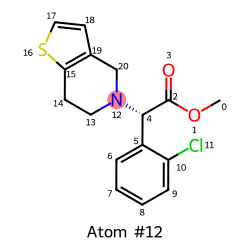

node_feats shape: torch.Size([21, 22])

  Full feature vector: tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1.])

One-hot encoded atomic number for Atom #12:
  Encoding: tensor([0., 1., 0., 0., 0., 0.])
  Corresponds to atomic number: 7

One-hot encoded degree for Atom #12:
  Encoding: tensor([0., 0., 1., 0.])
  Corresponds to degree: 3

One-hot encoded number of Hs for Atom #12:
  Encoding: tensor([1., 0., 0., 0.])
  Corresponds to number of Hs: 0

One-hot encoded hybridization for Atom #12:
  Encoding: tensor([0., 0., 1.])
  Corresponds to hybridization: SP3



In [9]:
rdmol = mols[df.query("name == 'Clopidogrel'").index[0]] # Try different molecules from the dataset
node_feats = get_node_feats(rdmol)

i = 12 # Atom index, can change it to see different atoms
IPythonConsole.drawOptions.addAtomIndices = True
display(Draw.MolsToGridImage([rdmol], molsPerRow=1, subImgSize=(250, 250), legends=[f"Atom #{i}"],
                             useSVG=True, highlightAtomLists=[[i]]))

print(f"node_feats shape: {node_feats.shape}\n")
print(f"  Full feature vector: {node_feats[i]}\n")

print(f"One-hot encoded atomic number for Atom #{i}:")
print(f"  Encoding: {node_feats[i, :6]}")
print(f"  Corresponds to atomic number: {x_map['atomic_num'][node_feats[i, :6].argmax().item()]}\n")

print(f"One-hot encoded degree for Atom #{i}:")
print(f"  Encoding: {node_feats[i, 6:10]}")
print(f"  Corresponds to degree: {x_map['degree'][node_feats[i, 6:10].argmax().item()]}\n")

print(f"One-hot encoded number of Hs for Atom #{i}:")
print(f"  Encoding: {node_feats[i, 10:14]}")
print(f"  Corresponds to number of Hs: {x_map['num_hs'][node_feats[i, 10:14].argmax().item()]}\n")

print(f"One-hot encoded hybridization for Atom #{i}:")
print(f"  Encoding: {node_feats[i, 14:17]}")
print(f"  Corresponds to hybridization: {x_map['hybridization'][node_feats[i, 14:17].argmax().item()]}\n")


Next, we need to get bond features, which represent the edges of our molecular graphs. PyTorch Geometric stores these as `edge_attr` in the `Data` object. But beofre extracting the bond features (whether it's a single, double, triple, or aromatic bond), we need to obtain `edge_index` from the molecule. `edge_index` is a tensor of shape `[2, num_edges]` that stores the indices of the atoms that are connected by an edge and that describe the edge connectivity of the graph. Being the standard way to represent the connectivity of a graph in PyTorch Geometric, `edge_index` is incredibly useful in GNNs, plus we can use it to extract the bond features and store them in the right order in the `edge_attr` tensor. If you are not familiar with `edge_index` or PyTorch Geometric's `Data` object, you can check out an [incredible tutorial](https://colab.research.google.com/drive/1p9vlVAUcQZXQjulA7z_FyPrB9UXFATrR#scrollTo=_l0tU8gum9eT) (one of many amazing resouces of this [Geometric Deep Learning course](https://geometricdeeplearning.com/lectures/)) by Chaitanya K. Joshi, Charlie Harris, and Ramon Viñas Torné that explains these concepts in detail, as well as the official [PyTorch Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html).

In [10]:
def get_edge_index(mol: Chem.Mol) -> torch.Tensor:
    """Generates an edge index tensor (edge connectivity) for an RDKit molecule object (mol)."""
    return torch.tensor(Chem.GetAdjacencyMatrix(mol), dtype=torch.long).to_sparse().indices()

def get_edge_attr(rdmol: Chem.Mol, edge_index: torch.Tensor) -> torch.Tensor:
    """Generates a feature tensor for each bond (edge) in an RDKit molecule object (rdmol)."""
    edge_attr = []

    for i, j in edge_index.T:
        bond = rdmol.GetBondBetweenAtoms(i.item(), j.item())
        edge_attr.append(e_map['bond_type'].index(str(bond.GetBondType())))
    
    edge_attr = torch.tensor(edge_attr, dtype=torch.long)
    return one_hot(edge_attr, num_classes=len(e_map['bond_type']), dtype=torch.float)

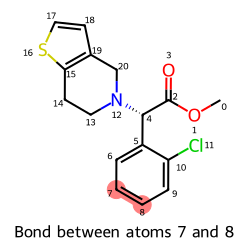

edge_index shape:
torch.Size([2, 46])

First 15 bonds in edge_index:
tensor([[ 0,  1,  1,  2,  2,  2,  3,  4,  4,  4,  5,  5,  5,  6,  6],
        [ 1,  0,  2,  1,  3,  4,  2,  2,  5, 12,  4,  6, 10,  5,  7]])

edge_attr shape: torch.Size([46, 4])

One-hot encoded bond type for bond between atoms 7 and 8:
  Encoding: tensor([0., 0., 0., 1.])
  Corresponds to bond type: AROMATIC


In [11]:
edge_index = get_edge_index(rdmol)
edge_attr = get_edge_attr(rdmol, edge_index)
i, j = 7, 8     # Change i and j to see different bonds

display(Draw.MolsToGridImage([rdmol], molsPerRow=1, subImgSize=(250, 250), legends=[f"Bond between atoms {i} and {j}"],
                             useSVG=True, highlightAtomLists=[[i, j]], highlightBondLists=[[rdmol.GetBondBetweenAtoms(i, j).GetIdx()]]))

print(f'edge_index shape:\n{edge_index.shape}\n')
print(f'First 15 bonds in edge_index:\n{edge_index[:, :15]}\n')
print(f'edge_attr shape: {edge_attr.shape}\n')

bond_idx = torch.where((edge_index.T == torch.tensor([i, j])).all(dim=1))[0].item()
print(f'One-hot encoded bond type for bond between atoms {i} and {j}:')
print(f'  Encoding: {edge_attr[bond_idx]}')
print(f'  Corresponds to bond type: {e_map["bond_type"][edge_attr[bond_idx].argmax().item()]}')

Now that we know how to feature extract the atoms and bonds, let's create a `torch_geometric` Dataset that will allow us to store molecular graphs as `Data` objects. If you are not familiar with PyTorch Geometric's `Data` object, you can check out the official [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) or the tutorial mentioned above.

The `download` method will download the dataset from the URL provided in the `url` attribute. This is similar to what we did in the first cell, but now we are using the `torch_geometric` `download_url` function. The `process` method will read the dataset and create a list of `Data` objects, where each `Data` object represents a molecular graph. The `Data` object will contain the `x` attribute, which stores the atom features, the `edge_index` attribute, which stores the connectivity of the graph, and the `edge_attr` attribute, which stores the bond features. The `y` attribute will store the target value, which in this case is the activity of the molecule. The `pos` attribute will store the 3D coordinates of the atoms, which we will extract from the molecule using RDKit.

We will omit `transform`, `pre_transform` and `pre_filter` for now, but you can check the documentation [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html) for more information.

In [12]:
class MolDataset(InMemoryDataset):
    """
    A PyTorch Geometric dataset for small molecules. For each molecule, the dataset contains the following:
        - x: Node features (atom type, degree, number of Hs, hybridization, aromaticity, presence in rings of size 3-6)
        - edge_index: Edge connectivity
        - edge_attr: Edge features (bond type)
        - pos: Node positions
        - y: Target value (activity)
        - name: Molecule name
    """

    url = 'https://github.com/vladislach/small-molecules/raw/main/structures.zip'

    def __init__(self, root, csv, transform=None):
        self.df = pd.read_csv(csv)
        super().__init__(root, transform)
        self.load(self.processed_paths[0])
    
    def raw_file_names(self):
        return [f"{id}.mol2" for id in self.df['id']]
    
    def processed_file_names(self):
        return ['data.pt']
    
    def download(self) -> None:
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.unlink(path)
    
    def process(self):
        data_list = []

        for path, row in zip(self.raw_paths, self.df.iterrows()):
            row = row[1]
            rdmol = Chem.MolFromMol2File(path)
            x = self.get_node_feats(rdmol)
            edge_index = self.get_edge_index(rdmol)
            edge_attr = self.get_edge_attr(rdmol, edge_index)
            pos = torch.tensor(rdmol.GetConformer().GetPositions(), dtype=torch.float)
            y = row['activity']
            name = row['name']
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, pos=pos, name=name)
            data_list.append(data)

        self.save(data_list, self.processed_paths[0])
    
    def get_node_feats(self, rdmol: Chem.Mol) -> torch.Tensor:
        """Generates a feature tensor for each atom (node) in an RDKit molecule object (rdmol)."""
        feats = []
        feats.append(
            one_hot(
                torch.tensor([x_map['atomic_num'].index(atom.GetAtomicNum()) for atom in rdmol.GetAtoms()]),
                num_classes=len(x_map['atomic_num']), dtype=torch.float
            )
        )
        feats.append(
            one_hot(
                torch.tensor([x_map['degree'].index(atom.GetTotalDegree()) for atom in rdmol.GetAtoms()]),
                num_classes=len(x_map['degree']), dtype=torch.float
            )
        )
        feats.append(
            one_hot(
                torch.tensor([x_map['num_hs'].index(atom.GetTotalNumHs()) for atom in rdmol.GetAtoms()]),
                num_classes=len(x_map['num_hs']), dtype=torch.float
            )
        )
        feats.append(
            one_hot(
                torch.tensor([x_map['hybridization'].index(str(atom.GetHybridization())) for atom in rdmol.GetAtoms()]),
                num_classes=len(x_map['hybridization']), dtype=torch.float
            )
        )
        feats.append(
            torch.tensor([atom.GetIsAromatic() for atom in rdmol.GetAtoms()], dtype=torch.float).view(-1, 1)
        )
        for i in range(3, 7):
            feats.append(
                torch.tensor([atom.IsInRingSize(i) for atom in rdmol.GetAtoms()], dtype=torch.float).view(-1, 1)
            )
        return torch.cat(feats, dim=-1)
    
    def get_edge_index(self, rdmol: Chem.Mol) -> torch.Tensor:
        """Generates an edge index tensor (edge connectivity) for an RDKit molecule object (mol)."""
        return torch.tensor(Chem.GetAdjacencyMatrix(rdmol), dtype=torch.long).to_sparse().indices()
    
    def get_edge_attr(self, rdmol: Chem.Mol, edge_index: torch.Tensor) -> torch.Tensor:
        """Generates a feature tensor for each bond (edge) in an RDKit molecule object (rdmol)."""
        edge_attr = []
        for i, j in edge_index.T:
            bond = rdmol.GetBondBetweenAtoms(i.item(), j.item())
            edge_attr.append(e_map['bond_type'].index(str(bond.GetBondType())))

        edge_attr = torch.tensor(edge_attr, dtype=torch.long)
        return one_hot(edge_attr, num_classes=len(e_map['bond_type']), dtype=torch.float)

In [13]:
dataset = MolDataset(root='data', csv='data/molecules.csv')

Let's now see what this dataset looks like and print out the `Data` objects it contains.

In [14]:
for data in dataset:
    print(data)

Data(x=[15, 22], edge_index=[2, 30], edge_attr=[30, 4], y=[1], pos=[15, 3], name='Ibuprofen')
Data(x=[17, 22], edge_index=[2, 34], edge_attr=[34, 4], y=[1], pos=[17, 3], name='Lidocaine')
Data(x=[30, 22], edge_index=[2, 62], edge_attr=[62, 4], y=[1], pos=[30, 3], name='Bimatoprost')
Data(x=[19, 22], edge_index=[2, 40], edge_attr=[40, 4], y=[1], pos=[19, 3], name='Diclofenac')
Data(x=[19, 22], edge_index=[2, 38], edge_attr=[38, 4], y=[1], pos=[19, 3], name='Metoprolol')
Data(x=[21, 22], edge_index=[2, 46], edge_attr=[46, 4], y=[1], pos=[21, 3], name='Clopidogrel')
Data(x=[17, 22], edge_index=[2, 34], edge_attr=[34, 4], y=[1], pos=[17, 3], name='Salbutamol')
Data(x=[30, 22], edge_index=[2, 66], edge_attr=[66, 4], y=[1], pos=[30, 3], name='Lenvatinib')
Data(x=[20, 22], edge_index=[2, 44], edge_attr=[44, 4], y=[1], pos=[20, 3], name='Tafamidis')
Data(x=[17, 22], edge_index=[2, 36], edge_attr=[36, 4], y=[1], pos=[17, 3], name='Naproxen')
Data(x=[32, 22], edge_index=[2, 68], edge_attr=[68, 4

And voila! We have successfully created a `torch_geometric` dataset that stores molecular graphs as `Data` objects with the atom and bond features we want to use. We can now use this dataset, for example, to train a GNN model to predict the activity of molecules.